In [2]:
import warnings
import os
import copy

from sklearnex import patch_sklearn
import numpy as np
import pandas as pd
from category_encoders import (
    BackwardDifferenceEncoder,
    BaseNEncoder,
    BinaryEncoder,
    CatBoostEncoder,
    CountEncoder,
    GLMMEncoder,
    HelmertEncoder,
    JamesSteinEncoder,
    LeaveOneOutEncoder,
    MEstimateEncoder,
    SummaryEncoder,
    TargetEncoder,
    WOEEncoder,
)
from sklearn.experimental import enable_iterative_imputer
from sklearn import set_config
from sklearn.base import clone as model_clone
from sklearn.cluster import *
from sklearn.impute import *
from sklearn.compose import *
from sklearn.cross_decomposition import *
from sklearn.decomposition import *
from sklearn.ensemble import *
from sklearn.feature_selection import *
from sklearn.gaussian_process import *
from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.multioutput import *
from sklearn.multiclass import *
from sklearn.naive_bayes import *
from sklearn.neighbors import *
from sklearn.neural_network import *
from sklearn.pipeline import *
from sklearn.preprocessing import *
from sklearn.kernel_approximation import *
from sklearn.svm import *
from sklearn.tree import *
from sklearn.utils import *
from sklearn.dummy import *
from sklearn.semi_supervised import *
from sklearn.discriminant_analysis import *
from sklearn.covariance import *
from collections import Counter
import sklearn
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.calibration import *
import joblib

pd.options.display.max_columns = 90
set_config(display="diagram")
warnings.filterwarnings("ignore")
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import InstanceHardnessThreshold
from imblearn.over_sampling import (
    ADASYN,
    SMOTE,
    RandomOverSampler,
    SVMSMOTE,
    SMOTENC,
    SMOTEN,
    BorderlineSMOTE,
    KMeansSMOTE,
)
%matplotlib inline
plt.style.use("fivethirtyeight")

import seaborn as sns

sns.set()
from joblib import parallel_backend
from joblib.memory import Memory

# patch_sklearn()
KAGGLE_ENV = 1
DATA_INPUT = '/kaggle/input/marketing-strategy-personalised-offer/'
DATA_OUTPUT = '/kaggle/working/'
cwd = os.path.abspath(os.getcwd())
if "mlop3n/Pycharm" in cwd or 'u164131' in cwd:
    KAGGLE_ENV = 0
    DATA_INPUT = 'kaggle/input/marketing-strategy-personalised-offer/'
    DATA_OUTPUT = 'kaggle/working/'
CACHE = Memory(DATA_OUTPUT + 'joblib', verbose=0)
patch_sklearn()
def gen_train_test(X, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=10
    )
    return X_train, X_test, y_train, y_test

def quick_test(X):
    clfs = [
        RandomForestClassifier(class_weight="balanced_subsample", random_state=42),
        DecisionTreeClassifier(class_weight="balanced", random_state=42),
        HistGradientBoostingClassifier(random_state=42),
        LogisticRegressionCV(max_iter=10000, class_weight="balanced", random_state=42),
    ]
    y = raw_data.target
    X_train, X_test, y_train, y_test = gen_train_test(X, y, test_size=0.5)
    for clf in clfs:
        y_pred = clf.fit(X_train, y_train).predict(X_test)
        score = f1_score(y_test, y_pred, average="macro")
        print(f"{clf.__class__.__name__} :: {score}")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


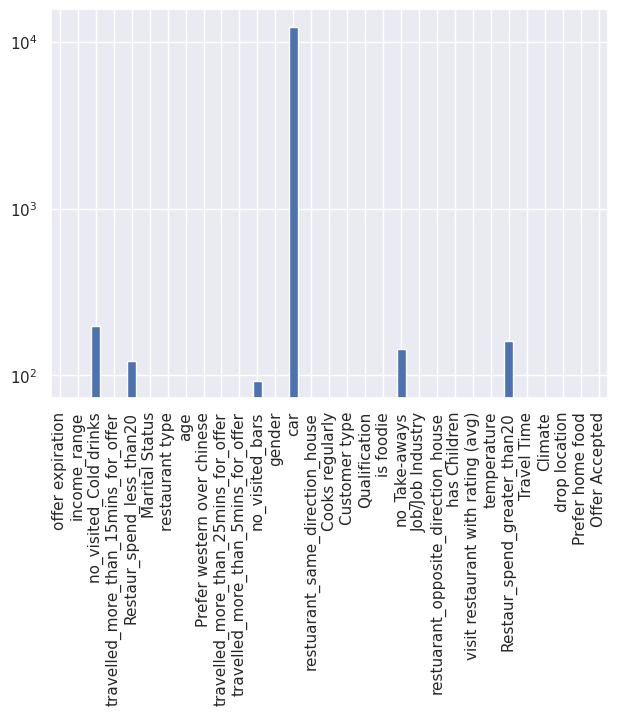

In [9]:
data  = pd.read_csv(DATA_INPUT + 'train_data.csv')
eval_data = pd.read_csv(DATA_INPUT + 'test_data.csv')
_ = data.isna().sum().plot(kind='bar',rot=90,logy=True)

### Convert days to Hours

In [5]:
data  = pd.read_csv(DATA_INPUT + 'train_data.csv')
eval_data = pd.read_csv(DATA_INPUT + 'test_data.csv')
def convert_to_hours(row):
    if "hours" in row['offer expiration']:
#         row['offer expiration'] = int(row['offer expiration'][:-5])
        row['offer expiration'] = 0
    elif "days" in row['offer expiration']:
#         row['offer expiration'] = int(row['offer expiration'][:-4])*24
        row['offer expiration'] = 1
    return row
def save_data():
    global data, eval_data
    data.to_parquet(DATA_OUTPUT + 'data.parquet')
    eval_data.to_parquet(DATA_OUTPUT + 'eval_data.parquet')

data = data.apply(convert_to_hours,axis=1)
eval_data = eval_data.apply(convert_to_hours,axis=1)
def pythonise_col_names(df: pd.DataFrame):
    col_names = list(df.columns)
    rename_stubs = {}
    for x in col_names:
        if x == 'Offer Accepted':
            r = 'target'
            rename_stubs[x]=r
        elif "/" in x:
            r = x.split('/')[1]
            r = r.replace(' ','_').lower()
            rename_stubs[x]=r
        elif "-" in x:
            r = x.replace('-','_').lower()
            r = r.replace(' ','_').lower()
            rename_stubs[x]=r
        elif " " in x:
            r = x.replace(' ','_').lower()
            rename_stubs[x]=r
        else:
            r = x.lower()
            rename_stubs[x] = r 
    return rename_stubs
data.rename(pythonise_col_names(data), inplace=True,axis=1)
eval_data.rename(pythonise_col_names(eval_data), inplace=True,axis=1)
gender_code = {
    'Male':0,
    'Female':1
}
def binarize_gender(row):
    global gender_code
    row['gender'] = gender_code[row['gender']]
    return row
data = data.apply(binarize_gender,axis=1)
eval_data = eval_data.apply(binarize_gender,axis=1)


ages_ord = ['below21','21', '26', '31', '36', '41', '46', '50plus']
ordinal_age_codes =  {x: idx for idx, x in enumerate(ages_ord)}
income_codes = { 
    'Less than ₹12500':1,
    '₹12500 - ₹24999' :2,
    '₹25000 - ₹37499' :3,
    '₹37500 - ₹49999' :4,
    '₹50000 - ₹62499' :5,
    '₹62500 - ₹74999' :6,
    '₹75000 - ₹87499' :7,
    '₹87500 - ₹99999' :8,
    '₹100000 or More' :9,
}

data['ordinal__income_range'] = 0
eval_data['ordinal__income_range'] = 0
data['ordinal__age'] = 0
eval_data['ordinal__age'] = 0

def codify_special_ordinal_range(row):
    global income_codes, ordinal_age_codes
    row['ordinal__income_range'] = income_codes[row['income_range']]
    row['ordinal__age'] = ordinal_age_codes[row['age']]
    return row
data = data.apply(codify_special_ordinal_range,axis=1)
eval_data = eval_data.apply(codify_special_ordinal_range,axis=1)

ordinal_category_codes = {
    '4~8': 3,
    'less1': 1,
    'never': 0,
    '1~3': 2,
    'gt8': 4,
    np.nan: np.nan}

# data = data.apply(codify_cold_drink_consumption,axis=1)
# eval_data = eval_data.apply(codify_cold_drink_consumption,axis=1)
ord_cols = ["restaur_spend_less_than20","no_take_aways","restaur_spend_greater_than20","no_visited_bars","no_visited_cold_drinks"]
col_ord_names = ["ordinal__" + x for x in ord_cols]
data[col_ord_names] = 0
eval_data[col_ord_names] = 0
def codify_ordinal_columns(row):
    global col_ord_names, ordinal_category_codes, ord_cols
    for ord_col,col_ord_name in zip(ord_cols,col_ord_names):
        try:
            row[col_ord_name] = int(ordinal_category_codes[row[ord_col]])
        except ValueError:
            row[col_ord_name] = ordinal_category_codes[row[ord_col]]
    return row
data = data.apply(codify_ordinal_columns,axis=1)
eval_data = eval_data.apply(codify_ordinal_columns,axis=1)

"""
Car Feature:
Label NaN as unknown for now
"""
data.car.fillna("unknown",inplace=True)
eval_data.car.fillna("unknown",inplace=True)

nominal_cs = ['restaurant_type','marital_status','climate',"drop_location","job_industry","customer_type","car","qualification"]
nominal_col_names = ["nominal__" + x for x in nominal_cs]
master_nominals= pd.concat([data[nominal_cs],eval_data[nominal_cs]], ignore_index=True,axis=0)
nominal_encoder = {nc:{} for nc in nominal_cs}
for c in nominal_cs:
    unique_vals = list(master_nominals[c].unique())
    nominal_codes = {x: idx for idx, x in enumerate(unique_vals)}
    nominal_encoder[c] = nominal_codes
data[nominal_col_names] = 0
eval_data[nominal_col_names] = 0
def codify_nominal_columns(row):
    global nominal_col_names, nominal_encoder, nominal_cs
    for nom_col,col_nom_name in zip(nominal_cs,nominal_col_names):
        try:
            row[col_nom_name] = int(nominal_encoder[nom_col][row[nom_col]])
        except ValueError:
            row[col_nom_name] = nominal_encoder[nom_col][row[nom_col]]
    return row
data = data.apply(codify_nominal_columns,axis=1)
eval_data = eval_data.apply(codify_nominal_columns,axis=1)

def drop_const_and_enc_columns(df):
    cols_to_drop = [
        'restaur_spend_less_than20',
        'no_take_aways',
        'restaur_spend_greater_than20',
        'no_visited_bars',
        'no_visited_cold_drinks',
        'restaurant_type',
        'marital_status',
        'climate',
        'qualification',
        'drop_location',
        'job_industry',
        'customer_type',
        'car',
        'income_range',
        "travelled_more_than_5mins_for_offer",
        'age'
    ]
    df = df.drop(cols_to_drop,axis=1)
    return df
data = drop_const_and_enc_columns(data)
eval_data = drop_const_and_enc_columns(eval_data)

data_original_col_order = [
    'offer_expiration',
    'ordinal__income_range',
    'ordinal__no_visited_cold_drinks',
    'travelled_more_than_15mins_for_offer',
    'ordinal__restaur_spend_less_than20',
    'nominal__marital_status',
    'nominal__restaurant_type',
    'ordinal__age',
    'prefer_western_over_chinese',
    'travelled_more_than_25mins_for_offer',
    'ordinal__no_visited_bars',
    'gender',
    'nominal__car',
    'restuarant_same_direction_house',
    'cooks_regularly',
    'nominal__customer_type',
    'nominal__qualification',
    'is_foodie',
    'ordinal__no_take_aways',
    'nominal__job_industry',
    'restuarant_opposite_direction_house',
    'has_children',
    'visit_restaurant_with_rating_(avg)',
    'temperature',
    'ordinal__restaur_spend_greater_than20',
    'travel_time',
    'nominal__climate',
    'nominal__drop_location',
    'prefer_home_food',
    'target'
]
eval_data_original_col_order = copy.deepcopy(data_original_col_order)
eval_data_original_col_order.remove('target')

data = data.loc[:,data_original_col_order]
eval_data = eval_data.loc[:,eval_data_original_col_order]
binary_features= [
    'offer_expiration',
    'travelled_more_than_15mins_for_offer',
    'prefer_western_over_chinese',
    'travelled_more_than_25mins_for_offer',
    'restuarant_same_direction_house',
    'cooks_regularly',
    'is_foodie',
    'restuarant_opposite_direction_house',
    'has_children',
    'prefer_home_food',
    'gender'
]
b_f_rn = {x:"binary__"+ x for x in binary_features}
data.rename(b_f_rn,axis=1,inplace=True)
eval_data.rename(b_f_rn,axis=1,inplace=True)
remaining_ordinals = {
    "visit_restaurant_with_rating_(avg)": "ordinal__rest_rating",
    "temperature": 'ordinal__temperature',
    "travel_time": "ordinal__travel_time"
}
def rename_remaining_ord(df):
    df = df.rename(remaining_ordinals,axis=1)
    return df
data = rename_remaining_ord(data)
eval_data = rename_remaining_ord(eval_data)

target_codes = {"Yes":1,"No":0}
def binarize_target(row):
    global target_codes
    row['target'] = target_codes[row['target']]
    return row
data = data.apply(binarize_target,axis=1)
imputer = IterativeImputer(estimator=RandomForestClassifier(class_weight='balanced',random_state=42,n_jobs=-1),sample_posterior=False,initial_strategy='most_frequent',random_state=42)
data.isna().sum()
X = data[eval_data.columns]
y = data.target
with parallel_backend('threading', n_jobs=24):
    data_enc = imputer.fit_transform(X)
    eval_data_enc = imputer.transform(eval_data)
    
data.loc[:,eval_data.columns] = data_enc
eval_data.loc[:,:] = eval_data_enc
data = data.astype(np.uint32)
eval_data = eval_data.astype(np.uint32)
save_data()

In [148]:
X = data[eval_data.columns]
y = data.target

In [149]:
poly_mutex= PolynomialFeatures(degree=4,include_bias=False,interaction_only=True)
poly_mutex.fit(X)
poly_f_data = pd.DataFrame(poly_mutex.transform(X),columns=poly_mutex.get_feature_names_out())
poly_f_eval_data = pd.DataFrame(poly_mutex.transform(eval_data),columns=poly_mutex.get_feature_names_out())

In [28]:
poly_f_data.corrwith(y).abs().sort_values(ascending=False)

binary__offer_expiration ordinal__no_visited_cold_drinks ordinal__no_visited_bars                    0.100714
binary__offer_expiration ordinal__no_visited_cold_drinks ordinal__temperature                        0.100356
binary__offer_expiration ordinal__restaur_spend_less_than20 ordinal__no_visited_bars                 0.097408
binary__offer_expiration ordinal__no_visited_cold_drinks                                             0.093796
ordinal__no_visited_cold_drinks ordinal__temperature                                                 0.093411
                                                                                                       ...   
binary__offer_expiration nominal__qualification nominal__job_industry                                0.000024
ordinal__age binary__restuarant_same_direction_house ordinal__temperature                            0.000016
ordinal__restaur_spend_less_than20 nominal__car binary__is_foodie                                    0.000010
nominal__c

In [ ]:
with parallel_backend('threading', n_jobs=48):
    mic = mutual_info_classif(poly_f_data,y)

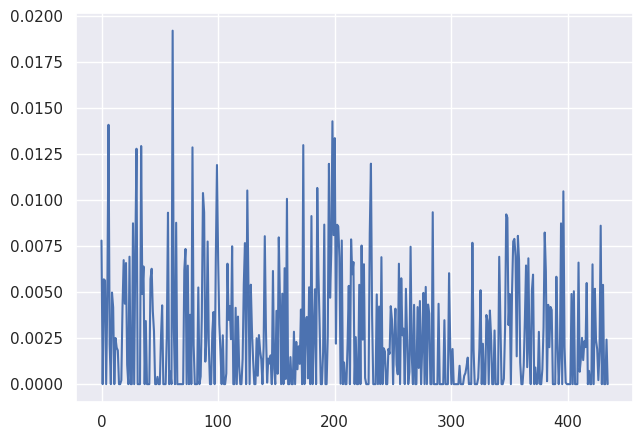

In [12]:
_ = plt.plot(mic)

In [119]:
good_poly = np.argsort(mic[np.where(mic>0.008)])
good_f = list(poly_f_data.columns[good_poly])

print(len(good_f))
# for e in good_f:
#     print(e)

310


In [123]:
X = poly_f_data[good_f]
y = data.target
min_c = poly_f_data[good_f].nunique().astype('int').to_numpy() + 1
# clf = RandomForestClassifier(class_weight='balanced',
#                              n_jobs=24,
# #                              max_features=None,
#                              )
class_prior = (y.value_counts()/X.shape[0]).sort_index().to_numpy()
clf = CategoricalNB(fit_prior=False,
                    alpha=0,
                    min_categories=min_c,
#                     class_prior=class_prior
                   )
categories_ = []
for c in X.columns:
    categories_.append(sorted(list(X[c].unique())))

work = make_pipeline(OrdinalEncoder(categories=categories_),clf)
X_train, X_test, y_train, y_test  = train_test_split( 
    X,
    y,
    test_size=0.2,
#     random_state=42,
    shuffle=True,
    stratify=y
)
with parallel_backend("threading"):
#     scores = cross_validate(clf,X,y,cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42),n_jobs=24,return_train_score=True,scoring='f1_macro')
    y_pred = work.fit(X_train,y_train).predict(X_test)
    print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.57      0.53      0.55      1160
           1       0.61      0.65      0.63      1316

    accuracy                           0.59      2476
   macro avg       0.59      0.59      0.59      2476
weighted avg       0.59      0.59      0.59      2476



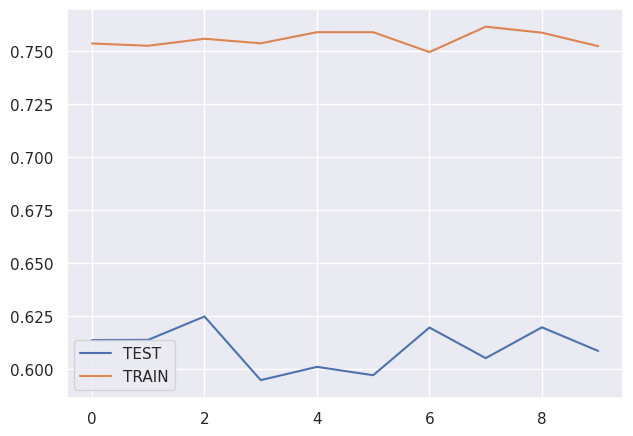

In [18]:
X = data[eval_data.columns]
y = data.target
clf = RandomForestClassifier(class_weight='balanced',
                             n_jobs=24,
                             max_features=None,
                             max_depth=8)
with parallel_backend("threading"):
    scores = cross_validate(clf,X,y,cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42),n_jobs=24,return_train_score=True,scoring='f1_macro')
_ = plt.plot(scores['test_score'],label='TEST')
_ = plt.plot(scores['train_score'],label='TRAIN')
_ = plt.legend()

In [139]:
import dtale
import dtale.app as dtale_app

dtale_app.USE_NGROK = True

In [11]:
poly_f_data.to_parquet('poly_train_4.parquet',compression='brotli')
# poly_f_eval_data.to_parquet('poly_eval_4.parquet')

In [10]:
poly_f_data = pd.read_parquet('poly_train_4.parquet')

In [12]:
poly_f_data.shape

(12379, 27840)